# T10: Tree-Based Methods

- TA: HUANG Xinrui

## Classification trees

- The `tree` library is used to construct classification and regression trees.
- We first use classification trees to analyze the `Carseats` data set.
- In these data, `Sales` is a continuous variable, and so we begin by recoding it as a binary variable.
- We use the `ifelse()` function to create a variable called `High`, which takes on a value of Yes if the `Sales` variable exceeds 8, and takes on a value of No otherwise.

In [1]:
# Fitting Classification Trees
set.seed(20231120)
library(tree)
library(ISLR2)

attach(Carseats)
High <- ifelse(Sales <= 8, "No", "Yes")
High <- factor(High)
Carseats <- data.frame(Carseats, High)
head(Carseats)
dim(Carseats)
detach(Carseats)

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,High
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>
1,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes,Yes
2,11.22,111,48,16,260,83,Good,65,10,Yes,Yes,Yes
3,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes,Yes
4,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes,No
5,4.15,141,64,3,340,128,Bad,38,13,Yes,No,No
6,10.81,124,113,13,501,72,Bad,78,16,No,Yes,Yes


[1] 400  12

- We now use the `tree()` function to fit a classification tree to predict `High` using all variables but `Sales`.
- The syntax of the `tree()` function is quite similar to that of the `lm()` function.

In [2]:
tree.carseats <- tree(High ~ . - Sales, Carseats)

- The `summary()` function lists the variables that are used as internal nodes in the tree, the number of terminal nodes, and the (training) error rate.

In [3]:
summary(tree.carseats)


Classification tree:
tree(formula = High ~ . - Sales, data = Carseats)
Variables actually used in tree construction:
[1] "ShelveLoc"   "Price"       "Income"      "CompPrice"   "Population" 
[6] "Advertising" "Age"         "US"         
Number of terminal nodes:  27 
Residual mean deviance:  0.4575 = 170.7 / 373 
Misclassification error rate: 0.09 = 36 / 400 

- We see that the training error rate is 9 %.
- For classification trees, the deviance reported in the output of `summary()` is given by
$$-2\sum_{m}\sum_{k}n_{mk}\log \hat{p}_{mk}$$
where $n_{mk}$ is the number of observations in the $m$-th terminal node that belong to the $k$-th class.
- A small deviance indicates a tree that provides a good fit to the (training) dataset.
- The residual mean deviance reported is simply the deviance divided by $n−|T_0|$, which in this case is $400−27 = 373$.

- We use the `plot()` function to display the tree structure and the `text()` function to display the node labels. 
- The argument `pretty = 0` instructs R to include the category names for any qualitative predictors rather than simply displaying a letter for each category.

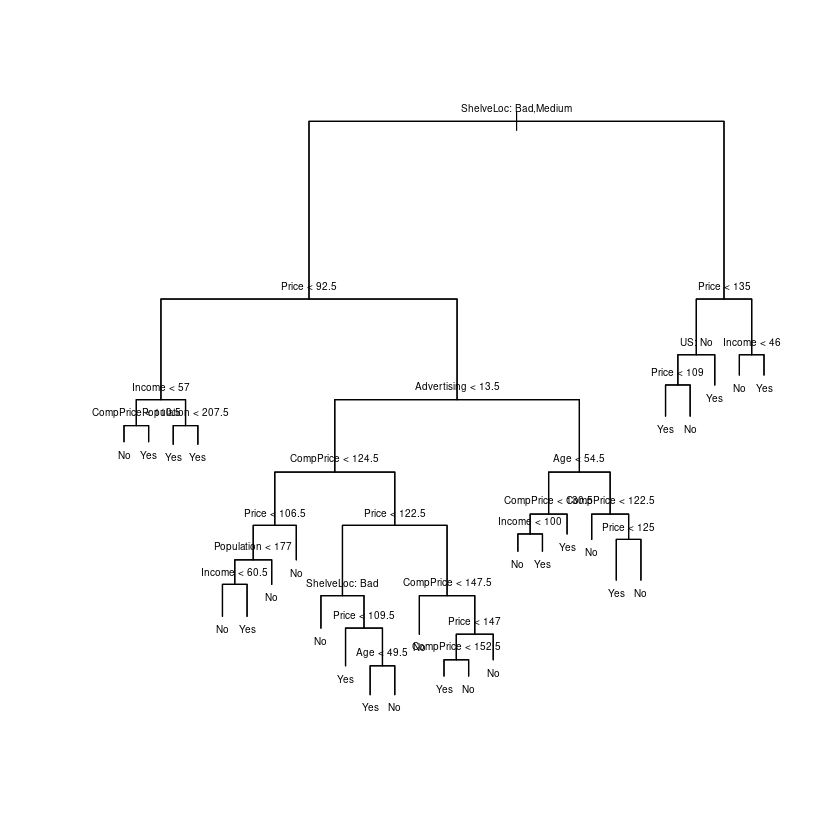

In [4]:
plot(tree.carseats)
text(tree.carseats, pretty = 0, cex = 0.5)

- If we just type the name of the tree object, R prints output corresponding to each branch of the tree:
- the split criterion (e.g. $\text{Price} < 92.5$)
- the number of observations in that branch
- the deviance
- the overall prediction for the branch ($\text{Yes}$ or $\text{No}$)
- and the fraction of observations in that branch that take on values of Yes and No. 
- Branches that lead to terminal nodes are indicated using asterisks (`*`).

In [5]:
tree.carseats

node), split, n, deviance, yval, (yprob)
      * denotes terminal node

  1) root 400 541.500 No ( 0.59000 0.41000 )  
    2) ShelveLoc: Bad,Medium 315 390.600 No ( 0.68889 0.31111 )  
      4) Price < 92.5 46  56.530 Yes ( 0.30435 0.69565 )  
        8) Income < 57 10  12.220 No ( 0.70000 0.30000 )  
         16) CompPrice < 110.5 5   0.000 No ( 1.00000 0.00000 ) *
         17) CompPrice > 110.5 5   6.730 Yes ( 0.40000 0.60000 ) *
        9) Income > 57 36  35.470 Yes ( 0.19444 0.80556 )  
         18) Population < 207.5 16  21.170 Yes ( 0.37500 0.62500 ) *
         19) Population > 207.5 20   7.941 Yes ( 0.05000 0.95000 ) *
      5) Price > 92.5 269 299.800 No ( 0.75465 0.24535 )  
       10) Advertising < 13.5 224 213.200 No ( 0.81696 0.18304 )  
         20) CompPrice < 124.5 96  44.890 No ( 0.93750 0.06250 )  
           40) Price < 106.5 38  33.150 No ( 0.84211 0.15789 )  
             80) Population < 177 12  16.300 No ( 0.58333 0.41667 )  
              160) Income < 60.5 6   0

- In order to properly evaluate the performance of a classification tree on these data, we must estimate the test error rather than simply computing the training error. 
- We split the observations into a training set and a test set, build the tree using the training set, and evaluate its performance on the test data. 

In [6]:
set.seed(2)
train <- sample(1:nrow(Carseats), 200)
Carseats.test <- Carseats[-train, ]
High.test <- High[-train]
tree.carseats <- tree(High ~ . - Sales, Carseats, subset = train)

- The `predict() `function can be used for this purpose. 
- In the case of a classification tree, the argument `type = "class"` instructs R to return the actual class prediction.
- This approach leads to correct predictions for around $76.5\%$ of the locations in the test data set.

In [7]:
set.seed(1)
tree.pred <- predict(tree.carseats, Carseats.test, type = "class")
head(tree.pred)
table(tree.pred, High.test)
sum(diag(table(tree.pred, High.test))) / length(High.test)

[1] Yes No  No  Yes No  No 
Levels: No Yes

         High.test
tree.pred  No Yes
      No  103  33
      Yes  14  50

[1] 0.765

## * Tree pruning

<font color='red'>Tree pruning is not usually used in practice. So we directly skip this part. You can take a look at it if you're interested.</font>

- Next, we consider whether pruning the tree might lead to improved results. 
- The function `cv.tree()` performs cross-validation to determine the optimal level of tree complexity; cost complexity pruning is used to select a sequence of trees for consideration. 
- We use the argument `FUN = prune.misclass` to indicate that we want the classification error rate to guide the cross-validation and pruning process, rather than the default for the `cv.tree()` function, which is deviance.

In [8]:
set.seed(10)
cv.carseats <- cv.tree(tree.carseats, FUN = prune.misclass)

- The `cv.tree()` function reports the __number of terminal nodes__ of each tree considered (size) as well as the corresponding __error rate__ and the __value of the cost-complexity parameter__ used ($k$, which corresponds to $\alpha$ in slides).

In [9]:
names(cv.carseats)
cv.carseats

[1] "size"   "dev"    "k"      "method"

$size
[1] 21 19 14  9  8  5  3  2  1

$dev
[1] 66 65 65 64 68 73 76 82 87

$k
[1] -Inf  0.0  1.0  1.4  2.0  3.0  4.0  9.0 18.0

$method
[1] "misclass"

attr(,"class")
[1] "prune"         "tree.sequence"

- Note that, despite the name, dev corresponds to the cross-validation error rate in this instance. 
- The tree with 9 terminal nodes results in the lowest cross-validation error rate, with 64 cross-validation errors.
- We plot the error rate as a function of both size and $k$.

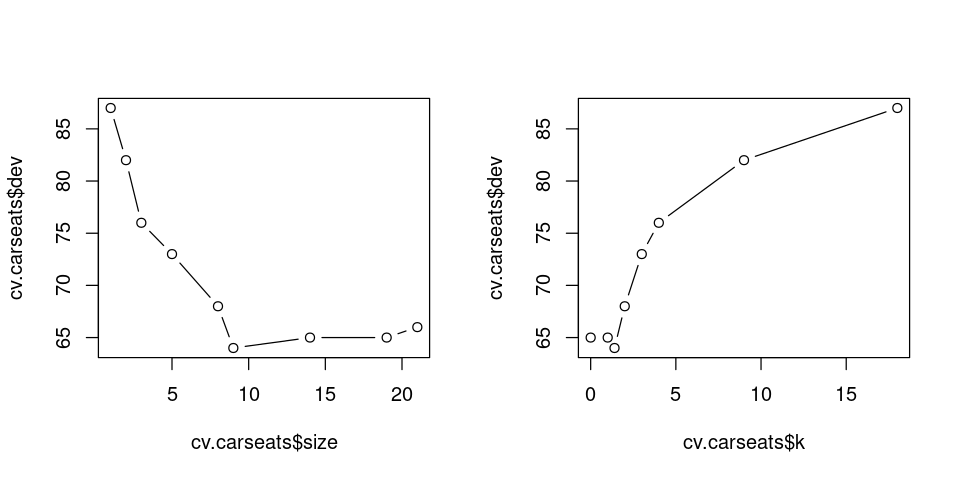

In [10]:
library(repr)
options(repr.plot.width = 8, repr.plot.height = 4)
par(mfrow = c(1, 2))
plot(cv.carseats$size, cv.carseats$dev, type = "b")
plot(cv.carseats$k, cv.carseats$dev, type = "b")

- We now apply the `prune.misclass()` function in order to prune the tree to obtain the 9-node tree.

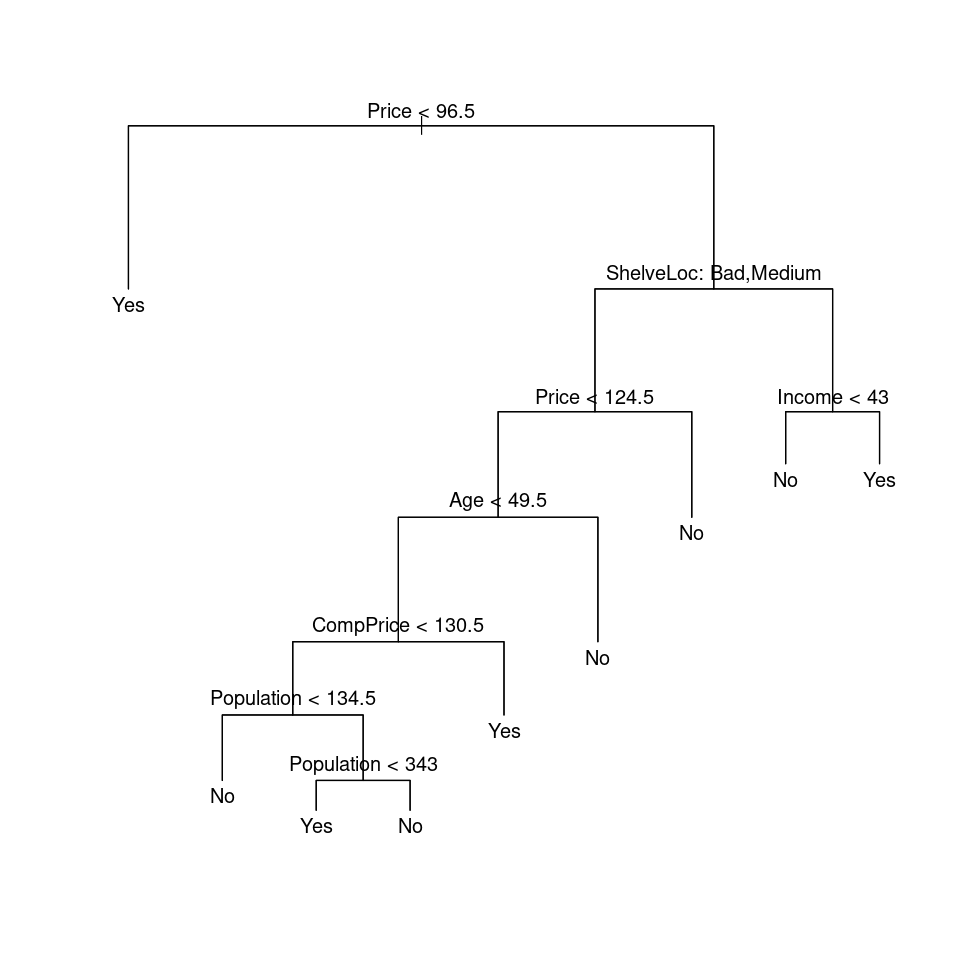

In [11]:
options(repr.plot.width = 8, repr.plot.height = 8)
prune.carseats <- prune.misclass(tree.carseats, best = 9)
plot(prune.carseats)
text(prune.carseats, pretty = 0)

- How well does this pruned tree perform on the test data set?
- Once again, we apply the `predict()` function.

In [12]:
tree.pred <- predict(prune.carseats, Carseats.test, type = "class")
table(tree.pred, High.test)
sum(diag(table(tree.pred, High.test))) / length(High.test)

         High.test
tree.pred No Yes
      No  97  25
      Yes 20  58

[1] 0.775

- Now $77.5\%$ of the test observations are correctly classified, so not only has the pruning process produced a more interpretable tree, but it has also improved the classification accuracy.
- If we increase the value of `best`, we obtain a larger pruned tree with lower classification accuracy:

         High.test
tree.pred  No Yes
      No  103  32
      Yes  14  51

[1] 0.77

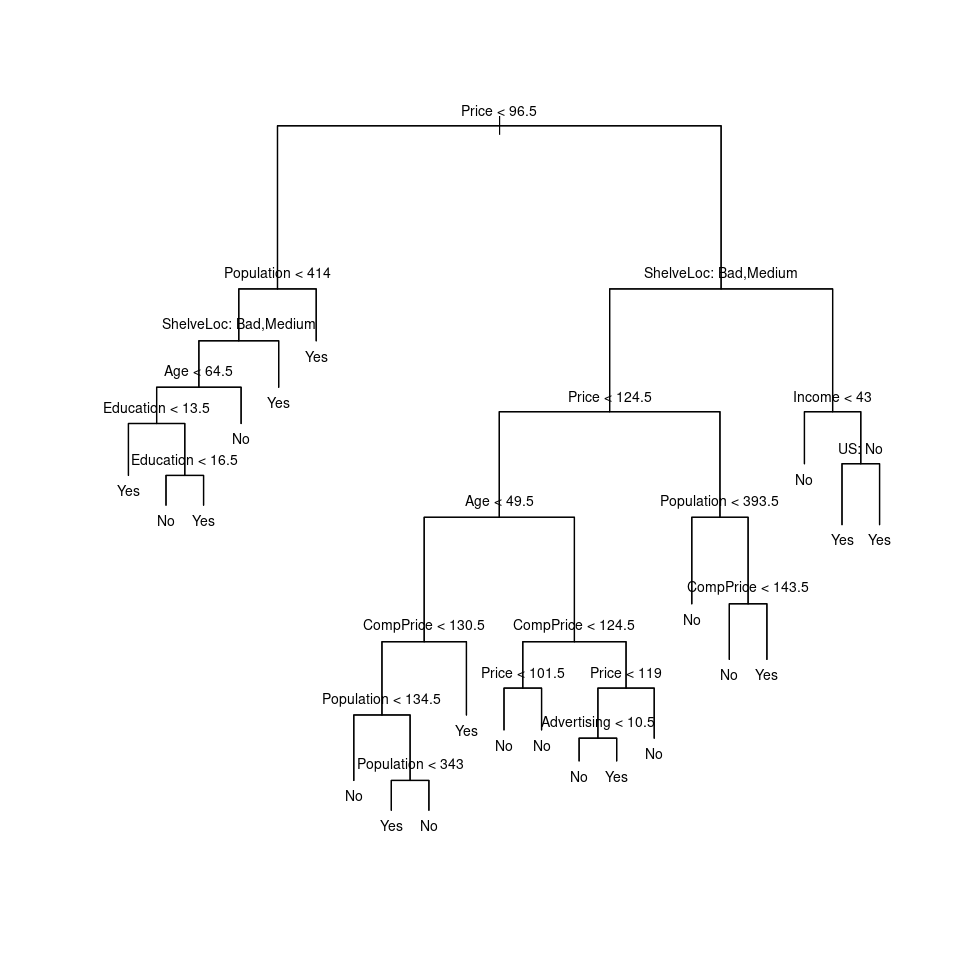

In [13]:
set.seed(10)
prune.carseats <- prune.misclass(tree.carseats, best = 21)
plot(prune.carseats)
text(prune.carseats, pretty = 0, cex = 0.7)
tree.pred <- predict(prune.carseats, Carseats.test, type = "class")
table(tree.pred, High.test)
sum(diag(table(tree.pred, High.test))) / length(High.test)

## Regression trees

- Here we fit a regression tree to the `Boston` data set. First, we create a training set and fit the tree to the training data.

In [14]:
set.seed(1)
library(MASS)
head(Boston)
dim(Boston)


Attaching package: ‘MASS’


The following object is masked from ‘package:ISLR2’:

    Boston




,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
2,0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
3,0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
4,0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
6,0.02985,0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7


[1] 506  14

In [15]:
# Fitting Regression Trees
train <- sample(1:nrow(Boston), nrow(Boston) / 2)
tree.boston <- tree(medv ~ ., Boston, subset = train)
summary(tree.boston)


Regression tree:
tree(formula = medv ~ ., data = Boston, subset = train)
Variables actually used in tree construction:
[1] "rm"    "lstat" "crim"  "age"  
Number of terminal nodes:  7 
Residual mean deviance:  10.38 = 2555 / 246 
Distribution of residuals:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-10.1800  -1.7770  -0.1775   0.0000   1.9230  16.5800 

- Note that the output of `summary()` indicates that only four variables have been used in constructing the tree. 
- In the context of a regression tree, deviance is simply the sum of squared errors for the tree. 
- We now plot the tree.

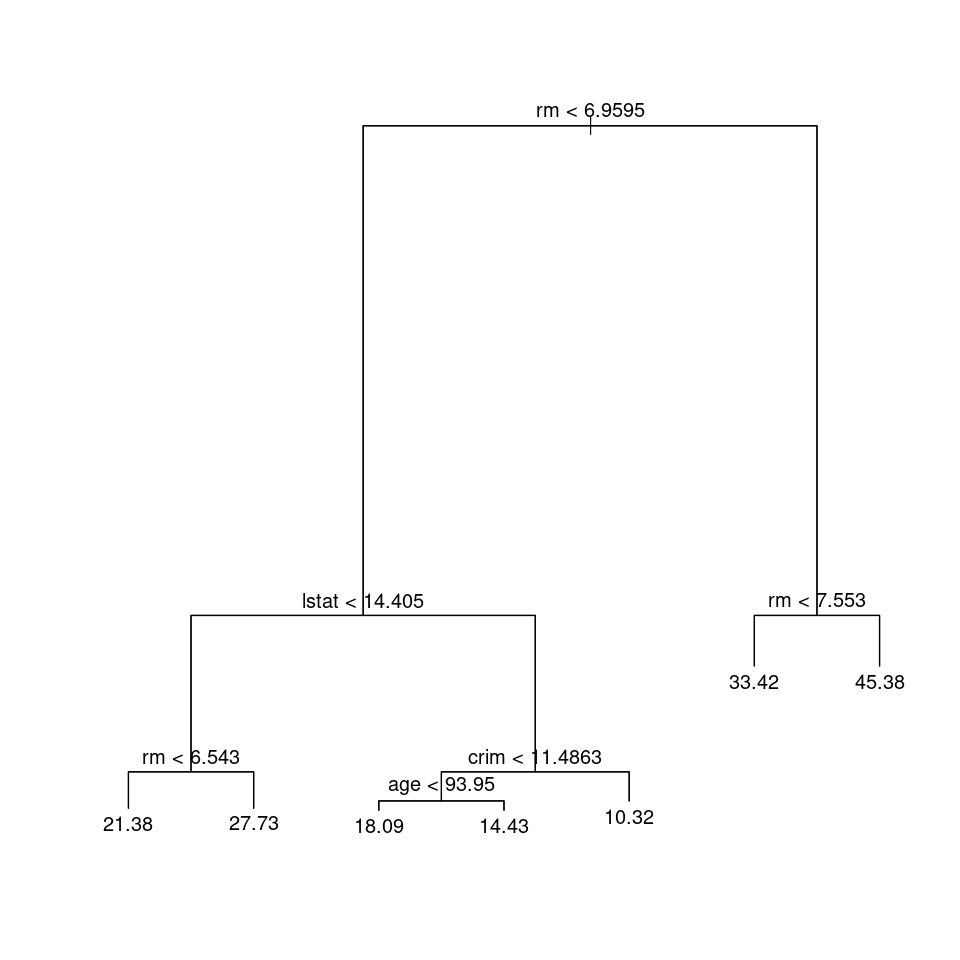

In [16]:
plot(tree.boston)
text(tree.boston, pretty = 0)

- Now we use the `cv.tree()` function to see whether pruning the tree will improve performance.

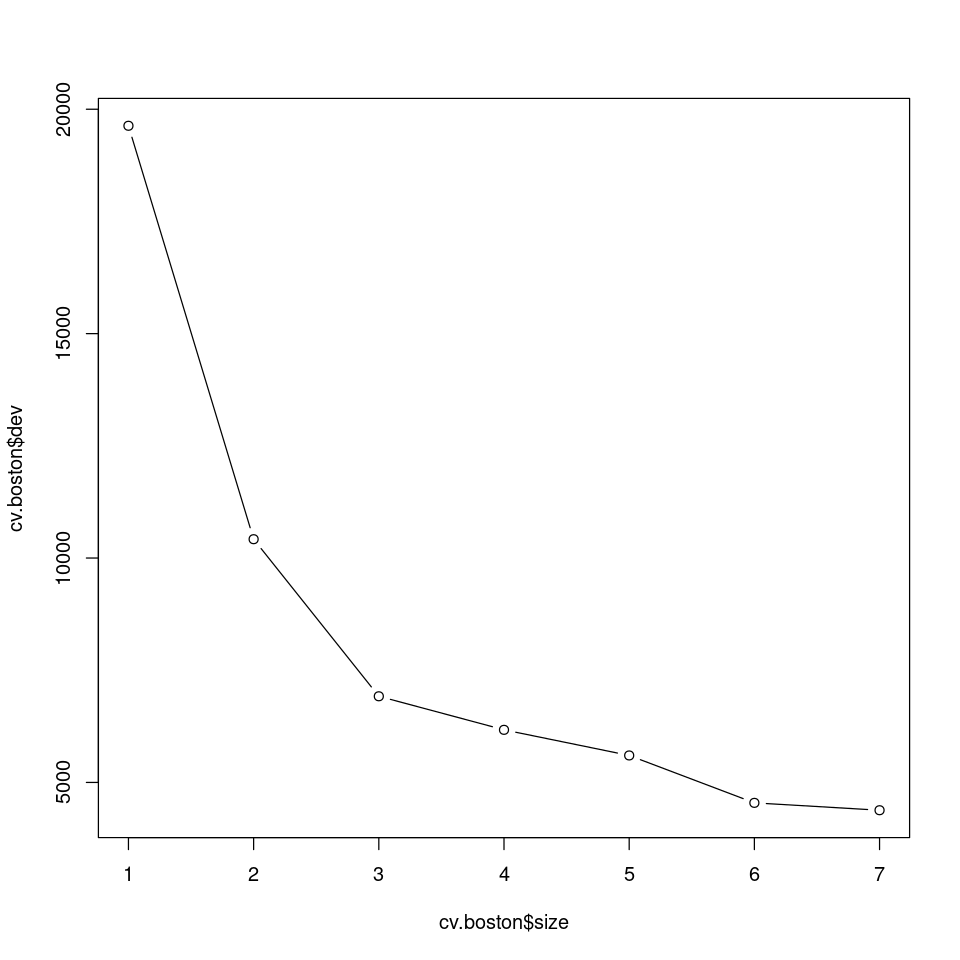

In [17]:
cv.boston <- cv.tree(tree.boston)
plot(cv.boston$size, cv.boston$dev, type = "b")

- In this case, the most complex tree is selected by cross-validation. 
- However, if we wish to prune the tree, we could do so as follows, using the `prune.tree()` function:

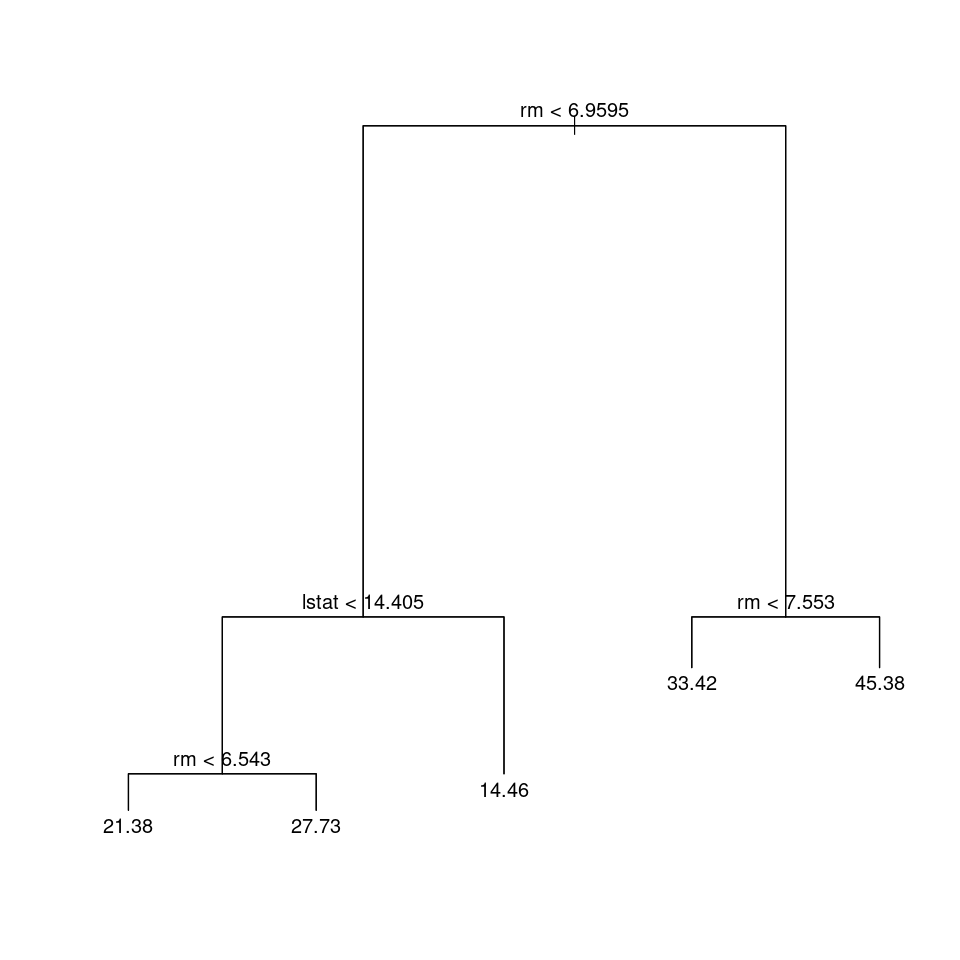

In [18]:
prune.boston <- prune.tree(tree.boston, best = 5)
plot(prune.boston)
text(prune.boston, pretty = 0)

[1] 35.28688

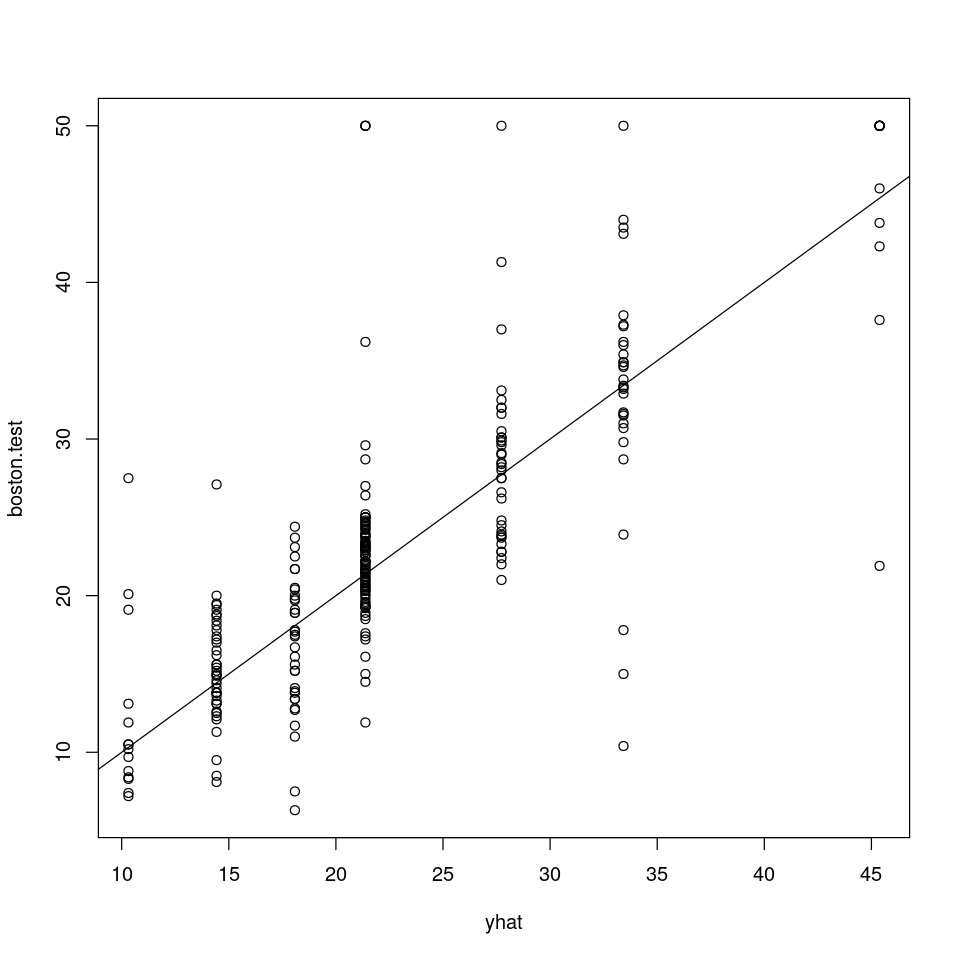

In [19]:
yhat <- predict(tree.boston, newdata = Boston[-train, ])
boston.test <- Boston[-train, "medv"]
plot(yhat, boston.test)
abline(0, 1)
mean((yhat - boston.test)^2)

## Bagging and Random Forest
- Here we apply bagging and random forests to the `Boston` dataset using the `randomForest` package in R. 
- Recall that bagging is simply a special case of a random forest with $m = p$. 
- Therefore, the `randomForest()` function can be used to perform both random forests and bagging. 
- We perform bagging as follows:

In [20]:
# Bagging and Random Forests
set.seed(1)
library(randomForest)
bag.boston <- randomForest(medv ~ ., data = Boston, subset = train, mtry = 13, importance = TRUE)
bag.boston

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.




Call:
 randomForest(formula = medv ~ ., data = Boston, mtry = 13, importance = TRUE,      subset = train) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 13

          Mean of squared residuals: 11.39601
                    % Var explained: 85.17

- The argument `mtry = 13` indicates that all 13 predictors should be considered for each split of the tree—in other words, that bagging should be done. 
- How well does this bagged model perform on the test set?

[1] 23.59273

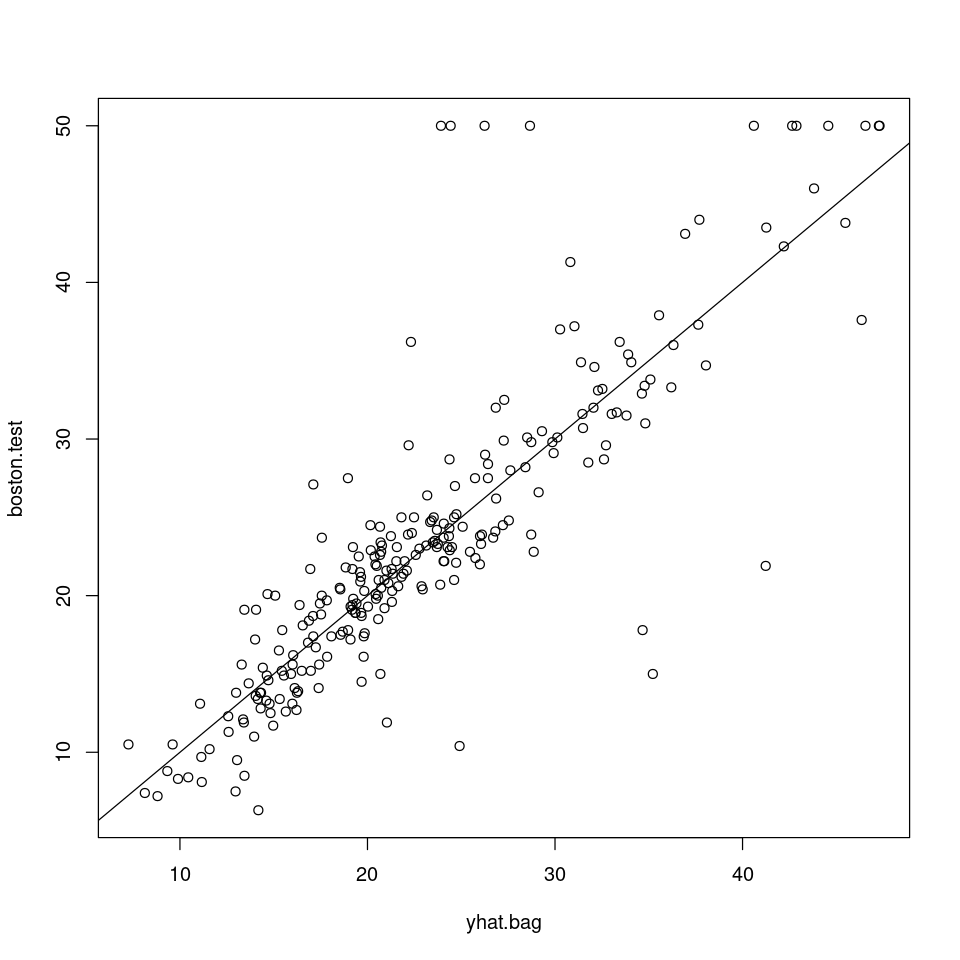

In [21]:
yhat.bag <- predict(bag.boston, newdata = Boston[-train, ])
plot(yhat.bag, boston.test)
abline(0, 1)
mean((yhat.bag - boston.test)^2)

- We could change the number of trees grown by `randomForest()` using the `ntree` argument:

In [22]:
bag.boston <- randomForest(medv ~ ., data = Boston, subset = train, mtry = 13, ntree = 25)
yhat.bag <- predict(bag.boston, newdata = Boston[-train, ])
mean((yhat.bag - boston.test)^2)

[1] 23.66716

- Growing a random forest proceeds in exactly the same way, except that we use a smaller value of the `mtry` argument. 
- By default, `randomForest()` uses $p/3$ variables when building a random forest of regression trees, and
$\sqrt{p}$ variables when building a random forest of classification trees.
- Here we use `mtry = 6`.

In [23]:
set.seed(1)
rf.boston <- randomForest(medv ~ ., data = Boston, subset = train, mtry = 6, importance = TRUE)
yhat.rf <- predict(rf.boston, newdata = Boston[-train, ])
mean((yhat.rf - boston.test)^2)

[1] 19.62021

- The test set MSE is 19.62; this indicates that random forests yielded an improvement over bagging in this case.

## * Random Forest: Randomization and regularization

Here we take a close look at why the randomized splitting procedure in random forest improves prediction. 
We will see that the randomization has the regularization effect, as demonstrated by analyzing the __degrees of freedom__.

In [24]:
library(ggplot2)
n <- 100
p <- 10
s <- 5
SNR <- 1
nrep <- 10

X <- matrix(rnorm(n * p), n, p)

beta <- rep(0, p)
beta[1:s] <- 1

y0 <- X %*% beta

sige <- sum(beta^2) / SNR

mtry_all <- c(0.1, 0.3, 0.5, 0.7, 1) * p
nodes_all <- c(1, 5, 10, 15, 20)
out <- data.frame()
for (i in 1:nrep) {
    y <- y0 + rnorm(n, 0, sqrt(sige))
    for (j in 1:length(mtry_all)) {
        for (k in 1:length(nodes_all)) {
            fit_rf <- randomForest(X, y = c(y), mtry = mtry_all[j], maxnodes = nodes_all[k])
            out <- rbind(out, data.frame(df = cov(y, predict(fit_rf, X)) / sige, mtry = paste0("mtry=", mtry_all[j]), maxnodes = nodes_all[k]))
            cat(i, "-th repitition, ", j, "-th mtry, ", k, "-th node finished.\n")
        }
    }
}


Attaching package: ‘ggplot2’


The following object is masked from ‘package:randomForest’:

    margin




1 -th repitition,  1 -th mtry,  1 -th node finished.
1 -th repitition,  1 -th mtry,  2 -th node finished.
1 -th repitition,  1 -th mtry,  3 -th node finished.
1 -th repitition,  1 -th mtry,  4 -th node finished.
1 -th repitition,  1 -th mtry,  5 -th node finished.
1 -th repitition,  2 -th mtry,  1 -th node finished.
1 -th repitition,  2 -th mtry,  2 -th node finished.
1 -th repitition,  2 -th mtry,  3 -th node finished.
1 -th repitition,  2 -th mtry,  4 -th node finished.
1 -th repitition,  2 -th mtry,  5 -th node finished.
1 -th repitition,  3 -th mtry,  1 -th node finished.
1 -th repitition,  3 -th mtry,  2 -th node finished.
1 -th repitition,  3 -th mtry,  3 -th node finished.
1 -th repitition,  3 -th mtry,  4 -th node finished.
1 -th repitition,  3 -th mtry,  5 -th node finished.
1 -th repitition,  4 -th mtry,  1 -th node finished.
1 -th repitition,  4 -th mtry,  2 -th node finished.
1 -th repitition,  4 -th mtry,  3 -th node finished.
1 -th repitition,  4 -th mtry,  4 -th node fin

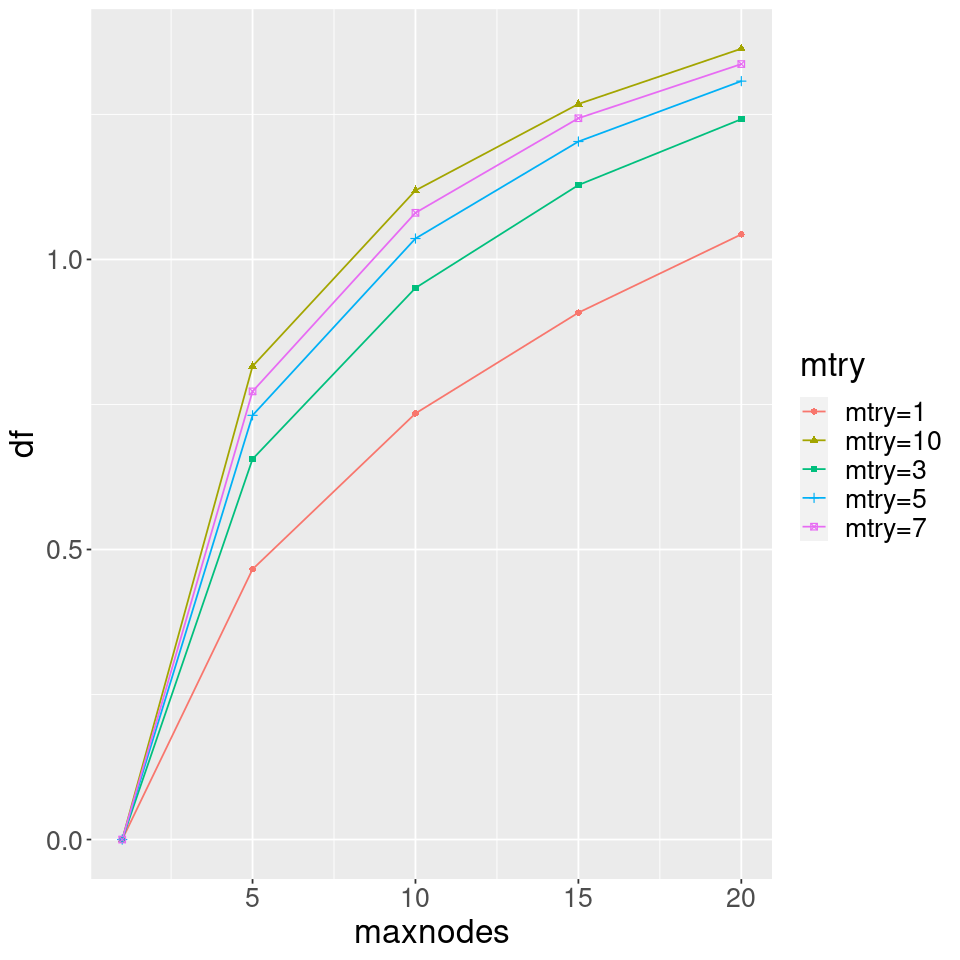

In [25]:
out1 <- aggregate(x = df ~ ., data = out, FUN = mean)
# out$maxnodes <- factor(out$maxnodes)
p <- ggplot(out1, aes(x = maxnodes, y = df, color = mtry)) +
    geom_line() +
    geom_point(aes(shape = mtry)) +
    theme(
        text = element_text(size = 20)
    )
p